# Developing Kaggle Bot Detection Algorithm


## Objectives:

1. Analyze the independent variables and select the ones that positively affect bot detection
2. Build a predictive model to detect users that are bots


## Exploratory Data Analysis


In [1]:
# Importing the Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from pandas_profiling import ProfileReport

In [2]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [3]:
# Loading the dataset.
data = pd.read_csv("/kaggle/input/kaggle-bot-account-detection/kaggle_bot_accounts.csv")
data.head()

,Unnamed: 0,NAME,GENDER,EMAIL_ID,IS_GLOGIN,FOLLOWER_COUNT,FOLLOWING_COUNT,DATASET_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,REGISTRATION_IPV4,REGISTRATION_LOCATION,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,ISBOT
0,0,Johnny KerrThomas,Male,jacksonalan@example.com,False,53.0,87.0,5.0,3.0,124.0,NaN,81.88.75.170,Argentina,16.0,10.0,3.0,NaN
1,1,Dwayne LarsenLara,Male,calvin80@example.com,True,16.0,67.0,5.0,NaN,26.0,24.97,NaN,New Zealand,14.0,5.0,2.0,NaN
2,2,NaN,Male,qbrown@example.net,True,44.0,81.0,4.0,17.0,125.0,7.75,159.202.103.178,Costa Rica,16.0,4.0,0.0,False
3,3,Russell SimmonsPhillips,Male,kimberlywagner@example.com,True,23.0,114.0,5.0,24.0,67.0,13.40,196.11.132.51,Italy,21.0,10.0,1.0,False
4,4,Jamie WilsonMartinez,Female,shaunbrooks@example.com,False,46.0,112.0,2.0,12.0,63.0,24.83,159.196.199.20,Belgium,10.0,6.0,2.0,False


### Data Descriptions and Exploratory Visualizations


In [4]:
# Extracting the dataset columns
data.columns

Index(['Unnamed: 0', 'NAME', 'GENDER', 'EMAIL_ID', 'IS_GLOGIN',
       'FOLLOWER_COUNT', 'FOLLOWING_COUNT', 'DATASET_COUNT', 'CODE_COUNT',
       'DISCUSSION_COUNT', 'AVG_NB_READ_TIME_MIN', 'REGISTRATION_IPV4',
       'REGISTRATION_LOCATION', 'TOTAL_VOTES_GAVE_NB', 'TOTAL_VOTES_GAVE_DS',
       'TOTAL_VOTES_GAVE_DC', 'ISBOT'],
      dtype='object')

In [5]:
# Display the size of the dataset
data.shape

(1321188, 17)

## Data Preprocessing


### Checking for missing values


In [6]:
data.isnull().sum()

Unnamed: 0                   0
NAME                     78164
GENDER                   77879
EMAIL_ID                 77814
IS_GLOGIN                77916
FOLLOWER_COUNT           77712
FOLLOWING_COUNT          78445
DATASET_COUNT            78567
CODE_COUNT               77926
DISCUSSION_COUNT         77722
AVG_NB_READ_TIME_MIN     78316
REGISTRATION_IPV4        78329
REGISTRATION_LOCATION    78290
TOTAL_VOTES_GAVE_NB      77705
TOTAL_VOTES_GAVE_DS      77934
TOTAL_VOTES_GAVE_DC      78030
ISBOT                    78500
dtype: int64

> The dataset has multiple columns with missing values.


In [7]:
# Displaying columns with missing values using sum and percentage
missing_values = data.isnull().sum().sort_values(ascending = True)
percent = ((data.isnull().sum()/data.isnull().count()) * 100) .sort_values(ascending=True)
missing_data = pd.concat([missing_values, percent], axis = 1, keys = ["Values", "Percentage"])
missing_data

,Values,Percentage
Unnamed: 0,0,0.000000
TOTAL_VOTES_GAVE_NB,77705,5.881449
FOLLOWER_COUNT,77712,5.881979
DISCUSSION_COUNT,77722,5.882736
EMAIL_ID,77814,5.889699
GENDER,77879,5.894619
IS_GLOGIN,77916,5.897420
CODE_COUNT,77926,5.898176
TOTAL_VOTES_GAVE_DS,77934,5.898782
TOTAL_VOTES_GAVE_DC,78030,5.906048


In [8]:
# Dealing with missing values
mean_total_votes = round(data["TOTAL_VOTES_GAVE_NB"].mean())
mean_follower_count = round(data["FOLLOWER_COUNT"].mean())
mean_discussion_count = round(data["DISCUSSION_COUNT"].mean())
mode_gender = data["GENDER"].mode()
mean_code_count = round(data["CODE_COUNT"].mean())
mean_total_votes_gave = round(data["TOTAL_VOTES_GAVE_NB"].mean())
mean_total_votes_ds = round(data["TOTAL_VOTES_GAVE_DS"].mean())
mean_total_votes_dc = round(data["TOTAL_VOTES_GAVE_DC"].mean())
avg_read_time = data["AVG_NB_READ_TIME_MIN"].mean()
mean_following_count = round(data["FOLLOWING_COUNT"].mean())
mean_dataset_count = round(data["DATASET_COUNT"].mean())
mode_islogin = data["IS_GLOGIN"].mode()


In [9]:
data["TOTAL_VOTES_GAVE_NB"].fillna(mean_total_votes, inplace=True)
data["FOLLOWER_COUNT"].fillna(mean_follower_count, inplace=True)
data["DISCUSSION_COUNT"].fillna(mean_discussion_count, inplace= True)
data["GENDER"].fillna(mode_gender[0], inplace=True)
data["CODE_COUNT"].fillna(mean_code_count, inplace=True)
data["TOTAL_VOTES_GAVE_NB"].fillna(mean_total_votes_gave, inplace=True)
data["TOTAL_VOTES_GAVE_DS"].fillna(mean_total_votes_ds, inplace = True)
data["TOTAL_VOTES_GAVE_DC"].fillna(mean_total_votes_dc, inplace = True)
data["AVG_NB_READ_TIME_MIN"].fillna(avg_read_time, inplace=True)
data["FOLLOWING_COUNT"].fillna(mean_following_count, inplace =True)
data["DATASET_COUNT"].fillna(mean_dataset_count, inplace = True)
data["IS_GLOGIN"].fillna(mode_islogin[0], inplace = True)

In [10]:
data.isna().sum()

Unnamed: 0                   0
NAME                     78164
GENDER                       0
EMAIL_ID                 77814
IS_GLOGIN                    0
FOLLOWER_COUNT               0
FOLLOWING_COUNT              0
DATASET_COUNT                0
CODE_COUNT                   0
DISCUSSION_COUNT             0
AVG_NB_READ_TIME_MIN         0
REGISTRATION_IPV4        78329
REGISTRATION_LOCATION    78290
TOTAL_VOTES_GAVE_NB          0
TOTAL_VOTES_GAVE_DS          0
TOTAL_VOTES_GAVE_DC          0
ISBOT                    78500
dtype: int64

In [11]:
data.dropna(inplace=True)

In [12]:
data.shape

(973661, 17)

In [13]:
# Getting some information about the columns.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 973661 entries, 3 to 1321185
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             973661 non-null  int64  
 1   NAME                   973661 non-null  object 
 2   GENDER                 973661 non-null  object 
 3   EMAIL_ID               973661 non-null  object 
 4   IS_GLOGIN              973661 non-null  bool   
 5   FOLLOWER_COUNT         973661 non-null  float64
 6   FOLLOWING_COUNT        973661 non-null  float64
 7   DATASET_COUNT          973661 non-null  float64
 8   CODE_COUNT             973661 non-null  float64
 9   DISCUSSION_COUNT       973661 non-null  float64
 10  AVG_NB_READ_TIME_MIN   973661 non-null  float64
 11  REGISTRATION_IPV4      973661 non-null  object 
 12  REGISTRATION_LOCATION  973661 non-null  object 
 13  TOTAL_VOTES_GAVE_NB    973661 non-null  float64
 14  TOTAL_VOTES_GAVE_DS    973661 non-n

In [14]:
# Dropping irrelevant columns.
data.drop("Unnamed: 0", axis=1, inplace=True)
data.drop("NAME", axis=1, inplace=True)
data.drop("EMAIL_ID", axis=1, inplace=True)
data.drop("REGISTRATION_LOCATION", axis=1, inplace=True)
data.drop("REGISTRATION_IPV4", axis=1, inplace=True)

In [15]:
data['IS_GLOGIN'] = data['IS_GLOGIN'].astype('object')

In [16]:
data

,GENDER,IS_GLOGIN,FOLLOWER_COUNT,FOLLOWING_COUNT,DATASET_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,ISBOT
3,Male,True,23.0,114.0,5.0,24.0,67.0,13.40,21.0,10.0,1.0,False
4,Female,False,46.0,112.0,2.0,12.0,63.0,24.83,10.0,6.0,2.0,False
5,Male,False,2.0,2.0,0.0,0.0,0.0,0.62,18.0,9.0,2.0,True
6,Male,False,46.0,36.0,0.0,16.0,77.0,22.32,18.0,9.0,1.0,False
9,Male,True,65.0,99.0,7.0,19.0,93.0,8.79,24.0,7.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1321179,Male,False,0.0,45.0,0.0,1.0,5.0,0.35,11.0,5.0,1.0,True
1321182,Male,True,46.0,7.0,7.0,21.0,66.0,21.65,23.0,5.0,0.0,False
1321183,Female,False,1.0,3.0,0.0,1.0,9.0,0.26,25.0,10.0,2.0,True
1321184,Female,True,20.0,60.0,6.0,14.0,44.0,23.39,22.0,10.0,3.0,False


In [17]:
# Obtaining the profile report.
#data.profile_report()

In [18]:
# Dropping highly correlated columns based on the profile report.
data.drop("DATASET_COUNT", axis=1, inplace=True)

In [19]:
# Obtaining a descriptive statistic of the data.
data.describe()

,FOLLOWER_COUNT,FOLLOWING_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC
count,973661.000000,973661.000000,973661.000000,973661.000000,973661.000000,973661.000000,973661.000000,973661.0000
mean,26.969640,45.049063,10.358159,65.853427,12.743482,17.536143,6.529476,1.5302
std,22.316049,38.293567,8.001530,46.131753,9.279559,4.475935,2.225885,1.0909
min,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,3.000000,0.0000
25%,2.000000,3.000000,1.000000,13.000000,1.980000,14.000000,5.000000,1.0000
50%,27.000000,44.000000,10.000000,66.000000,12.742246,18.000000,7.000000,2.0000
75%,46.000000,77.000000,17.000000,105.000000,20.590000,21.000000,8.000000,2.0000
max,70.000000,120.000000,25.000000,150.000000,29.990000,25.000000,10.000000,3.0000


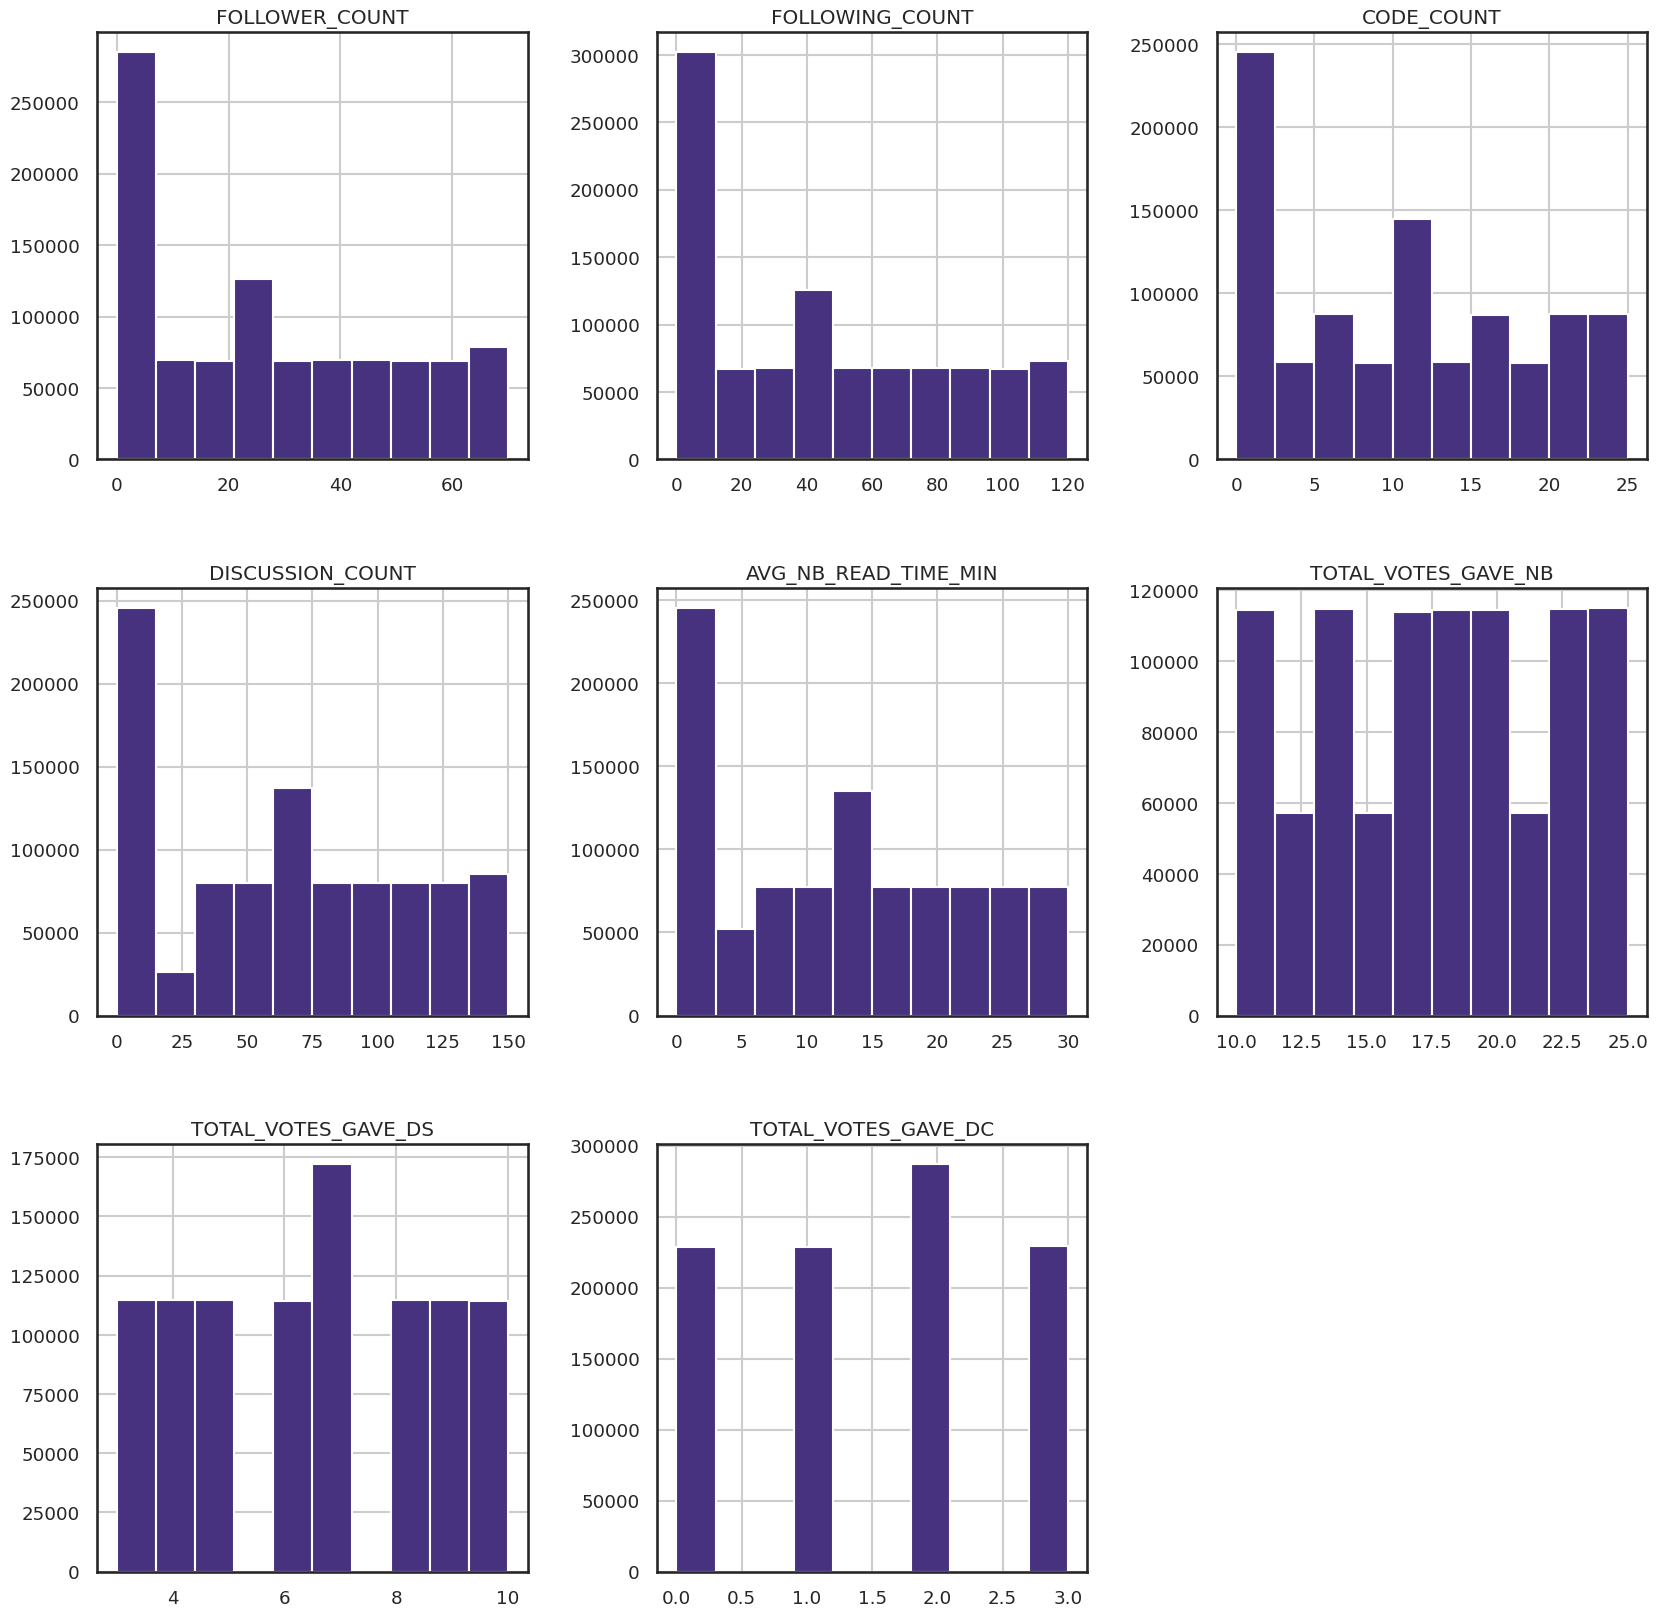

In [20]:
data.hist(figsize=(20,20))
plt.show()

In [21]:
print("Percentage of fake accounts is {:.1f}% and non-fake accounts is: {:.1f}%".format(
    data[data['ISBOT'] == True].shape[0] / data.shape[0]*100,
    data[data['ISBOT'] == False].shape[0] / data.shape[0]*100))

Percentage of fake accounts is 26.8% and non-fake accounts is: 73.2%


> It can be observed from the above code that the dataset is inbalanced (skewed towards non fake accounts).


## Down sample


In [22]:
bot = data[data['ISBOT'] == True]


In [23]:
not_bot = data[data['ISBOT'] == False]


In [24]:
# Impoting the library
from sklearn.utils import resample

In [25]:
# Dealing with imbalanced dataset.
# Random under sampling.
not_bot_downsampled = resample(not_bot,
                                   replace=False,  # sample without replacement
                                   n_samples= 260813,  # to match minority class
                                   )  # reproducible results

In [26]:
not_bot_downsampled

,GENDER,IS_GLOGIN,FOLLOWER_COUNT,FOLLOWING_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,ISBOT
205828,Female,True,51.0,99.0,6.0,77.0,14.12,21.0,4.0,1.0,False
868705,Male,True,61.0,95.0,5.0,132.0,11.13,19.0,7.0,1.0,False
423984,Male,True,25.0,100.0,13.0,143.0,22.40,19.0,6.0,3.0,False
808666,Male,True,11.0,54.0,11.0,89.0,16.50,14.0,3.0,3.0,False
1239531,Male,False,36.0,47.0,20.0,73.0,27.25,12.0,10.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...
234572,Male,True,44.0,94.0,10.0,66.0,16.91,12.0,4.0,0.0,False
490441,Female,True,15.0,119.0,3.0,92.0,5.36,22.0,6.0,1.0,False
1294054,Male,False,34.0,98.0,15.0,112.0,10.74,12.0,3.0,2.0,False
710977,Male,False,21.0,101.0,15.0,76.0,24.61,10.0,3.0,3.0,False


In [27]:
main_data = pd.concat([not_bot_downsampled, bot])

In [28]:
# Checking the balanced dataset.
main_data["ISBOT"].value_counts()

False    260813
True     260813
Name: ISBOT, dtype: int64

# Encoding


In [29]:
from sklearn.preprocessing import LabelEncoder

In [30]:
le = LabelEncoder()

In [31]:
# Performing Label Encoding on the target variable.
main_data["ISBOT"] = le.fit_transform(main_data["ISBOT"])

In [32]:
main_data

,GENDER,IS_GLOGIN,FOLLOWER_COUNT,FOLLOWING_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,ISBOT
205828,Female,True,51.0,99.0,6.0,77.0,14.12,21.0,4.0,1.0,0
868705,Male,True,61.0,95.0,5.0,132.0,11.13,19.0,7.0,1.0,0
423984,Male,True,25.0,100.0,13.0,143.0,22.40,19.0,6.0,3.0,0
808666,Male,True,11.0,54.0,11.0,89.0,16.50,14.0,3.0,3.0,0
1239531,Male,False,36.0,47.0,20.0,73.0,27.25,12.0,10.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
1321174,Female,False,2.0,1.0,0.0,7.0,0.35,23.0,8.0,2.0,1
1321176,Male,False,1.0,3.0,1.0,11.0,1.41,13.0,5.0,2.0,1
1321177,Female,False,2.0,3.0,1.0,3.0,0.80,23.0,9.0,3.0,1
1321179,Male,False,0.0,45.0,1.0,5.0,0.35,11.0,5.0,1.0,1


## Feature Extraction


In [33]:
features = main_data.drop("ISBOT", axis = 1)
features

,GENDER,IS_GLOGIN,FOLLOWER_COUNT,FOLLOWING_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC
205828,Female,True,51.0,99.0,6.0,77.0,14.12,21.0,4.0,1.0
868705,Male,True,61.0,95.0,5.0,132.0,11.13,19.0,7.0,1.0
423984,Male,True,25.0,100.0,13.0,143.0,22.40,19.0,6.0,3.0
808666,Male,True,11.0,54.0,11.0,89.0,16.50,14.0,3.0,3.0
1239531,Male,False,36.0,47.0,20.0,73.0,27.25,12.0,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1321174,Female,False,2.0,1.0,0.0,7.0,0.35,23.0,8.0,2.0
1321176,Male,False,1.0,3.0,1.0,11.0,1.41,13.0,5.0,2.0
1321177,Female,False,2.0,3.0,1.0,3.0,0.80,23.0,9.0,3.0
1321179,Male,False,0.0,45.0,1.0,5.0,0.35,11.0,5.0,1.0


In [34]:
# Performing one-hot encoding on the features
features = pd.get_dummies(features)
features

,FOLLOWER_COUNT,FOLLOWING_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,GENDER_Female,GENDER_Male,IS_GLOGIN_False,IS_GLOGIN_True
205828,51.0,99.0,6.0,77.0,14.12,21.0,4.0,1.0,1,0,0,1
868705,61.0,95.0,5.0,132.0,11.13,19.0,7.0,1.0,0,1,0,1
423984,25.0,100.0,13.0,143.0,22.40,19.0,6.0,3.0,0,1,0,1
808666,11.0,54.0,11.0,89.0,16.50,14.0,3.0,3.0,0,1,0,1
1239531,36.0,47.0,20.0,73.0,27.25,12.0,10.0,1.0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1321174,2.0,1.0,0.0,7.0,0.35,23.0,8.0,2.0,1,0,1,0
1321176,1.0,3.0,1.0,11.0,1.41,13.0,5.0,2.0,0,1,1,0
1321177,2.0,3.0,1.0,3.0,0.80,23.0,9.0,3.0,1,0,1,0
1321179,0.0,45.0,1.0,5.0,0.35,11.0,5.0,1.0,0,1,1,0


In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler()

In [37]:
# Normalizing the features
norm_features = scaler.fit_transform(features)

In [38]:
features = pd.DataFrame(norm_features, columns = features.columns)

In [39]:
features

,FOLLOWER_COUNT,FOLLOWING_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,GENDER_Female,GENDER_Male,IS_GLOGIN_False,IS_GLOGIN_True
0,0.728571,0.825000,0.24,0.513333,0.470824,0.733333,0.142857,0.333333,1.0,0.0,0.0,1.0
1,0.871429,0.791667,0.20,0.880000,0.371124,0.600000,0.571429,0.333333,0.0,1.0,0.0,1.0
2,0.357143,0.833333,0.52,0.953333,0.746916,0.600000,0.428571,1.000000,0.0,1.0,0.0,1.0
3,0.157143,0.450000,0.44,0.593333,0.550183,0.266667,0.000000,1.000000,0.0,1.0,0.0,1.0
4,0.514286,0.391667,0.80,0.486667,0.908636,0.133333,1.000000,0.333333,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
521621,0.028571,0.008333,0.00,0.046667,0.011671,0.866667,0.714286,0.666667,1.0,0.0,1.0,0.0
521622,0.014286,0.025000,0.04,0.073333,0.047016,0.200000,0.285714,0.666667,0.0,1.0,1.0,0.0
521623,0.028571,0.025000,0.04,0.020000,0.026676,0.866667,0.857143,1.000000,1.0,0.0,1.0,0.0
521624,0.000000,0.375000,0.04,0.033333,0.011671,0.066667,0.285714,0.333333,0.0,1.0,1.0,0.0


In [40]:
target = main_data["ISBOT"]

In [41]:
target

205828     0
868705     0
423984     0
808666     0
1239531    0
          ..
1321174    1
1321176    1
1321177    1
1321179    1
1321183    1
Name: ISBOT, Length: 521626, dtype: int64

In [2]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(features,target)
print(model.feature_importances_)
feat_importance = pd.Series(model.feature_importances_,index=features.columns)
feat_importance.nlargest(10).plot(kind = 'barh')
plt.show()

NameError: name 'features' is not defined

## Performing cross validation on the dataset


In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [44]:
# define the logistic regression model
logreg_model = LogisticRegression()

# define the k-fold cross validation procedure
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# perform cross validation and generate predictions
target_pred = cross_val_predict(logreg_model, features, target, cv=kfold)

# generate the confusion matrix and classification report
cm = confusion_matrix(target, target_pred)
cr = classification_report(target, target_pred)
acc = accuracy_score(target, target_pred)

In [45]:
acc

0.9983743141637879

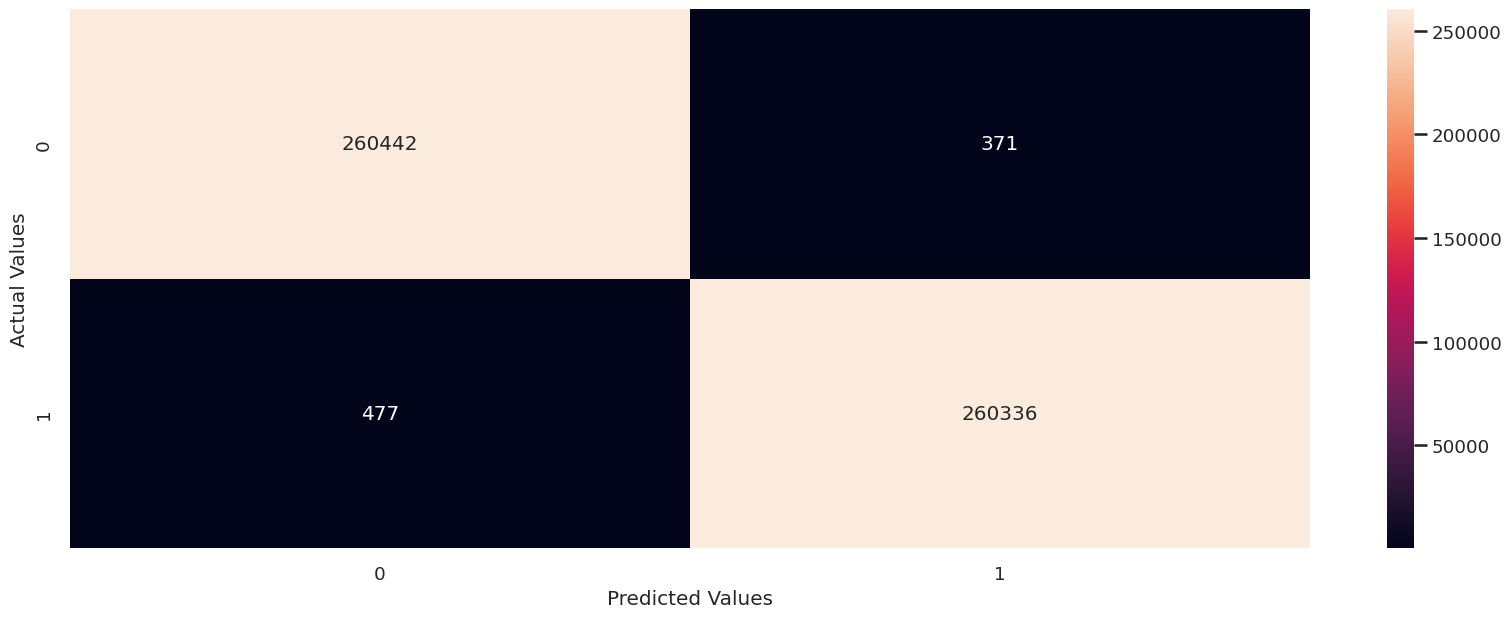

In [46]:
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [47]:
#Importing the Decision tree classifier
from sklearn.tree import DecisionTreeClassifier

In [48]:
# define the logistic regression model
decision_tree_model = DecisionTreeClassifier()

# define the k-fold cross validation procedure
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# perform cross validation and generate predictions
target_pred = cross_val_predict(decision_tree_model, features, target, cv=kfold)

# generate the confusion matrix and classification report
cm = confusion_matrix(target, target_pred)
cr = classification_report(target, target_pred)
acc = accuracy_score(target, target_pred)

In [49]:
acc

1.0

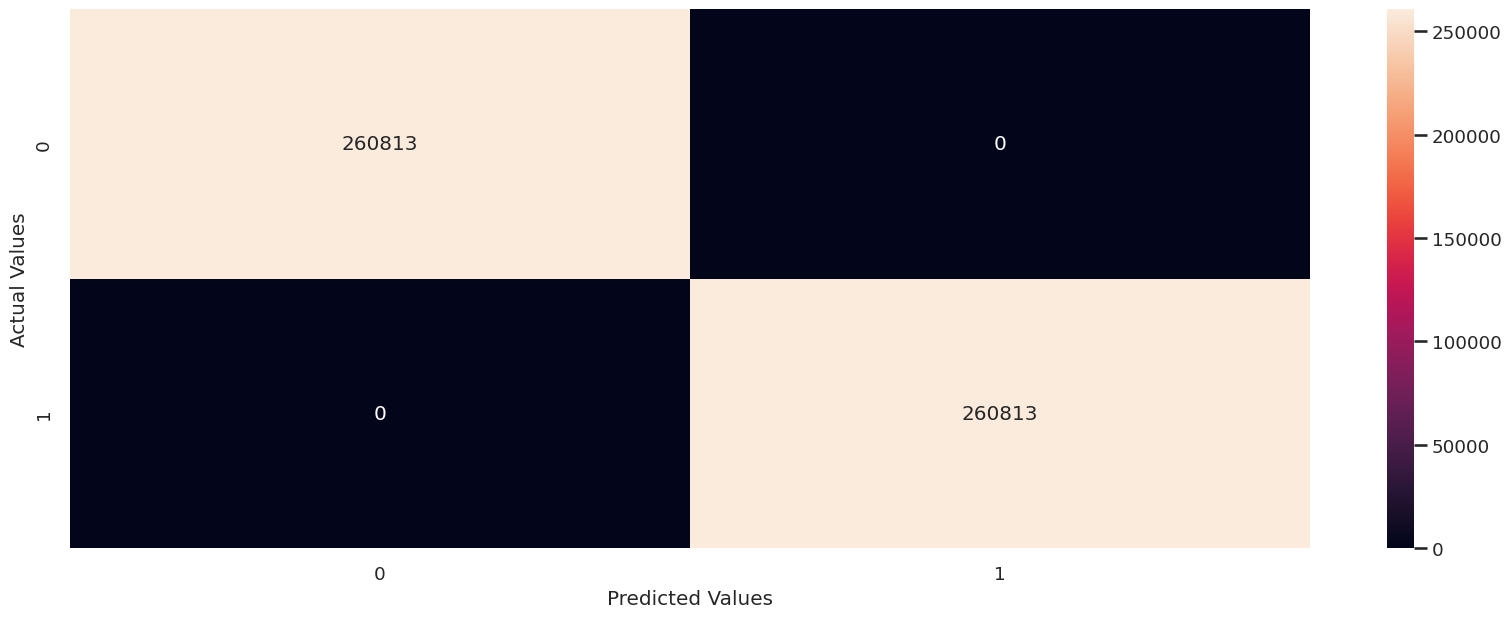

In [50]:
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [51]:
# Importing the support vector machine. 
from sklearn.svm import SVC

In [52]:
# define the SVM model
support_vector_model = SVC(kernel = 'poly')

# define the k-fold cross validation procedure
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# perform cross validation and generate predictions
target_pred = cross_val_predict(support_vector_model, features, target, cv=kfold)

# generate the confusion matrix and classification report
cm = confusion_matrix(target, target_pred)
cr = classification_report(target, target_pred)
acc = accuracy_score(target, target_pred)

In [53]:
acc

0.9989456047052869

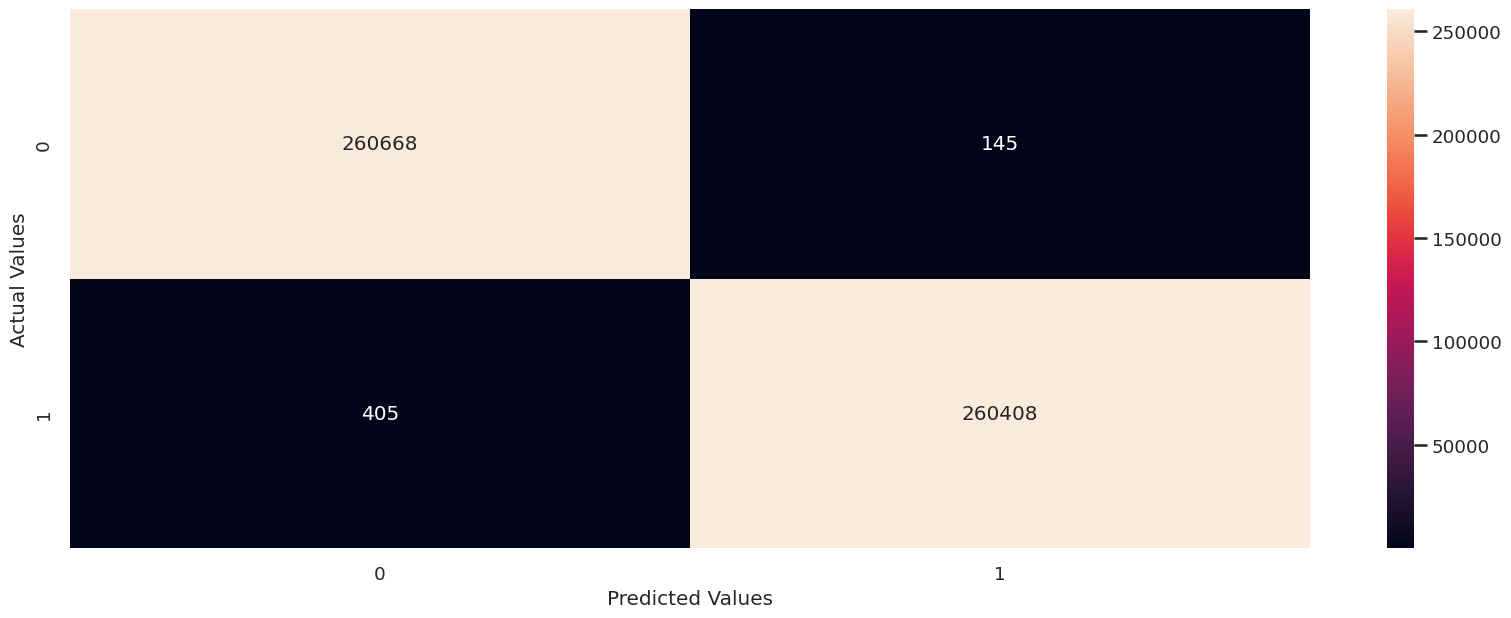

In [54]:
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()